---
title: "Interactive Session: Complementing anthropogenic GHG emissions with natural GHG emissions and fluxes"
---

## About the Data
Methane (CH₄) emissions from vegetated wetlands are estimated to be the largest natural source of methane in the global CH₄ budget, contributing to roughly one third of the total of natural and anthropogenic emissions. Wetland CH₄ is produced by microbes breaking down organic matter in the oxygen deprived environment of inundated soils. Due to limited data availability, the details of the role of wetland CH₄ emissions have thus far been underrepresented. Using the Earth Observation SIMulator version (LPJ-EOSIM) of the Lund-Potsdam-Jena Dynamic Global Vegetation Model (LPJ-DGVM) global CH₄ emissions from wetlands are estimated at 0.5 x 0.5 degree spatial resolution. By simulating wetland extent and using characteristics of inundated areas, such as wetland soil moisture, temperature, and carbon content, the model provides estimates of CH₄ quantities emitted into the atmosphere. The LPJ-EOSIM Wetland Methane Emissions dataset consists of global daily and monthly model estimates of terrestrial wetland methane emissions from 1990 to the present, with data added every two months. The monthly dataset is computed by summing the daily data for each month. The estimates are regularly used in conjunction with NASA’s Goddard Earth Observing System (GEOS) model to simulate the impact of wetlands and other methane sources on atmospheric methane concentrations, to compare against satellite and airborne data, and to improve understanding and prediction of wetland emissions. This is a new version and replaces the LPJ-wsl dataset previously available in the GHG Center.

## Requirements
- Set up Python Environment - See setup_instructions.md in the `/setup/` folder

## Learning Objectives
- How to use `U.S. GHG Center STAC Catalog` to access `Wetland Methane Emissions, LPJ-wsl Model` data
- How to use `earthaccess` to find MERRA-2 data
- How to visualize datasets using `folium` and perform zonal statistics
- How to plot time series for `MERRA-2` variables and `Wetland Methane Emissions, LPJ-wsl Model` and analyze the results

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac `endpoint. The collection processed in this notebook is the Wetland Methane Emissions, LPJ-wsl Model data product
2. Pass the STAC item into the raster API `/stac/tilejson.json` endpoint
3. Access the MERRA-2 data for different variables (precipitation rate, surface soil moisture)
4. Define the spatial region of interest
5. Using plugins from `folium` to visualize two tiles (side-by-side), allowing time point comparison
6. After the visualization, perform zonal statistics for a given polygon
7. Plot monthly time series for LPJ-wetland emission and different MERRA-2 dataset and analyze them

## Data

1. Monthly LPJ Wetland CH4 Emissions (US GHG Center STAC)

## Setup
Import the required Python libraries by running the next cell. 

In [290]:
# import earthaccess
import os
import requests
import pandas as pd
import geopandas as gpd
os.environ['USE_PYGEOS'] = '0'
import folium
import folium.plugins
import seaborn as sns
import glob
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import branca.colormap as cm
from folium import TileLayer 
from pystac_client import Client 
from datetime import datetime
import stackstac
import xarray as xr
import rioxarray as rxr
import surfaceAreaGrid
from cartopy import crs as ccrs
import cartopy.feature as cf

## Querying the STAC API
Search for the LPJ Wetland Methane Emissions Data using the Raster API and its STAC collection name!

In [291]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://earth.gov/ghgcenter/api/stac"
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Please use the collection name similar to the one used in STAC collection
# Name of the collection for wetland methane monthly emissions 
collection_name = "lpjeosim-wetlandch4-monthgrid-v1"

In [292]:
# Fetching the collection from STAC collections using appropriate endpoint
# Using the Client module of pystac_client

catalog = Client.open(STAC_API_URL)

# Pick the collection
# Select GRA2PES collection: browse item_assets, spatial and temporal extent
collection = catalog.get_collection(collection_name)
collection

<CollectionClient id=lpjeosim-wetlandch4-monthgrid-v1>

Here we are examining the contents of our `collection` under `summaries`. We notice the data is available from January 1980 to May 2021. By looking at `dashboard: time density`, we can see that these observations are collected monthly.

In [293]:
# Get items from this collection, examine temporal extent of each
items = list(collection.get_items())
print(f"Found {len(items)} items in {collection_name} collection.")

Found 417 items in lpjeosim-wetlandch4-monthgrid-v1 collection.


In [294]:
# Examining the first item in the collection
# Keep in mind that a list starts from 0, 1, 2,... therefore ‘[0]’ is referring to the first item in the list/collection 
items[0]

<Item id=lpjeosim-wetlandch4-monthgrid-v1-202409>

Below, we enter minimum and maximum values to provide our upper and lower bounds in 'rescale_values.'

## Define the Spatial Area of Interest
For this example, our spatial area of interest (AOI) will be a region in the state of Louisiana (LA). The state of Louisiana encompasses a diverse range of non-tidal and tidal freshwater wetlands including palustrine, lacustrine, riverine, estuarine, and marine wetlands. These ecosystems cover roughly one-third of the state according to the [U.S. Fish and Wildlife Service](https://www.fws.gov/wetlands/data/Water-Summary-Reports/National-Water-Summary-Wetland-Resources-Louisiana.pdf), making Louisiana an ideal site for monitoring the natural source of methane emissions.

Our AOI is defined by a polygon, and there are several methods for defining our polygon - here we read in a GEOJSON created by using [geojson.io](geojson.io). If you want to look at data over a different region, try drawing your own AOI and dropping the GEOJSON into this directory!

We also include an example of how to read geospatial information from a shapefile.

In [295]:
# We'll use geopandas to read our GEOJSON, which defines a polygon over our AOI.
louisiana_aoi = gpd.read_file('./louisiana.geojson')

In [296]:
## Method #2 of defining a polygon - using a shapefile!
## An individual shapefile has a .shp extension,
## but comes packaged with several supplemental files, typically in .zip format.
## Here we have unpacked the contents of a .zip from the Census Bureau
## in data/cb_2018_us_state_20m
## We'll use geopandas to read the .shp file found there and isolate Louisiana.
## Uncomment the next two lines to use the shapefile!
# 
#gdf = gpd.read_file('./data/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')
#louisiana_aoi = gdf[gdf['NAME'] == 'Louisiana']

## Opening and Exploring Wetland Methane Emissions Data Using the Raster API

Let's visualize methane emissions on an interactive map using `folium`.


In [297]:
items[0].properties

{'end_datetime': '2024-09-30T00:00:00+00:00',
 'start_datetime': '2024-09-01T00:00:00+00:00',
 'datetime': None}

In [298]:
# To access the year value from each item more easily, 
# this will let us query more explicitly by year and month (e.g., 2020-02)
items = {item.properties["start_datetime"][:7]: item for item in items} 


# Set the asset value to the appropriate parameter 
asset_name = 'ensemble-mean-ch4-wetlands-emissions'

## Visualizing CH₄ Emissions


In [299]:
# Select colormap
color_map = "magma"
# Set the minimum and maximum values to provide our upper and lower bounds
rescale_values = {'max': 0.000000001, 'min': 0.0}


new_date1, new_date2, new_date3 = '2021-05', '2021-06','2021-07'
# Reading the tiles from raster api
tile_date_1 = requests.get(
    f"{RASTER_API_URL}/collections/{items[new_date1].collection_id}/items/{items[new_date1].id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
tile_date_1


tile_date_2 = requests.get(
    f"{RASTER_API_URL}/collections/{items[new_date2].collection_id}/items/{items[new_date2].id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
tile_date_2


tile_date_3 = requests.get(
    f"{RASTER_API_URL}/collections/{items[new_date3].collection_id}/items/{items[new_date3].id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
tile_date_3


# Interactive visulaization 
map_ = folium.Map(location=(30,-90), zoom_start=5)

# May 2021
tile1 = TileLayer(
    tiles=tile_date_1["tiles"][0],
    attr="GHG",
    name=new_date1
)
tile1.add_to(map_)

# June 2021
tile2 = TileLayer(
    tiles=tile_date_2["tiles"][0],
    attr="GHG",
    name=new_date2
)
tile2.add_to(map_)

# July 2021
tile3 = TileLayer(
    tiles=tile_date_3["tiles"][0],
    attr="GHG",
    name=new_date3
)
tile3.add_to(map_)

folium.GeoJson(louisiana_aoi, name="louisiana, USA").add_to(map_)
folium.LayerControl(collapsed=False,position='bottomleft').add_to(map_)

# Add legend
colormap = cm.LinearColormap(colors = ['#2c115f','#721f81','#b73779','#f1605d','#feb078'], vmin = 0, vmax = 0.000000003 )
colormap.caption = 'kg CH₄/m²/s'

svg_style = '<style>svg#legend {font-size: 14px; background-color: white;}</style>'
map_.get_root().header.add_child(folium.Element(svg_style))
map_.add_child(colormap)


# Visualizing the map
map_

Click through the layers of this map to see how wetland emissions ramp up over the course of the wet season!

## Generate Statistics and Time Series for Methane Emissions in 2020 and 2021

In [313]:
# You can change the years here to look at whichever consecutive two years you want.
years = [2020,2021]
items = catalog.search(
    collections=[collection_name],  # Specify the collection
    datetime=f"{years[0]}-01-01/{years[1]}-12-31",
    limit=24
)
items_2020_2021 = items.items()

<xarray.DataArray 'stackstac-832e5ff502af6903e5fc4ff92bb07e45' (time: 24,
                                                                band: 3,
                                                                y: 360, x: 720)> Size: 149MB
dask.array<fetch_raster_window, shape=(24, 3, 360, 720), dtype=float64, chunksize=(1, 1, 360, 720), chunktype=numpy.ndarray>
Coordinates: (12/15)
  * time            (time) datetime64[ns] 192B NaT NaT NaT NaT ... NaT NaT NaT
    id              (time) <U39 4kB 'lpjeosim-wetlandch4-monthgrid-v1-202112'...
  * band            (band) <U36 432B 'era5-ch4-wetlands-emissions' ... 'ensem...
  * x               (x) float64 6kB -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
  * y               (y) float64 3kB 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5
    end_datetime    (time) <U25 2kB '2021-12-31T00:00:00+00:00' ... '2020-01-...
    ...              ...
    proj:bbox       object 8B {90.0, 180.0, -90.0, -180.0}
    title           (band) <U69 828B '(Monthly) Wetland Methane Emissions, ER...
    proj:geometry   object 8B {'type': 'Polygon', 'coordinates': [[[-180.0, -...
    proj:transform  object 8B {0.5, 0.0, -0.5, 1.0, -180.0, 90.0}
    proj:wkt2       <U302 1kB 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS...
    epsg            int64 8B 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-180.0, -90.0, 180.0, 90.0), r...
    crs:         epsg:4326
    transform:   | 0.50, 0.00,-180.00|\n| 0.00,-0.50, 90.00|\n| 0.00, 0.00, 1...
    resolution:  0.5

In [ ]:
# The bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
# The following function generates statistics for the assigned parameter 
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"]["ensemble-mean-ch4-wetlands-emissions"]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"],
    }

In [ ]:
# Generate the stats for the data

stats = [generate_stats(item.to_dict(), louisiana_aoi) for item in items_2020_2021]
stats

In [ ]:
# Manipulating and cleaning the stats output from previous cell
def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df


df = clean_stats(stats)
df.head(5)

In [ ]:
df['year'] = pd.to_datetime(df['datetime']).dt.year
df['month'] = pd.to_datetime(df['datetime']).dt.month
df

### Visualizing the Data as a Time Series
We can now plot the time-series of the wetland methane emissions for the state of Louisiana for the 2023-2024 (January - December) period.

In [ ]:
fig = plt.figure(figsize=(20, 10))

# Set the plot elements 
sns.lineplot(
    df,
    x = 'month', 
    y = 'sum',
    hue= 'year',
    palette='flare'
)


# Set the labels for the X and Y axis and assign a title for the plot 
# plt.legend()
plt.xlabel("months")
plt.ylabel("CH4 emissions g/m2")
plt.title("CH4 emission Values for Louisiana for 2023 and 2024")

## Alternatively,

Use stackstac to read in the dataset into xarray and use rioxarray to generate the timeseries

In [ ]:
# Read in LPJ data to xarray DataArray
ds = stackstac.stack(items.item_collection(),epsg=4326).squeeze()
# Let's take a look
ds

### Use rioxarray to select data within AOI
The `rio.clip` function has a few options for selection of grid cells relative to the specified geometry. Here we will use the default functionality. See [documentation]('https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_dataset.RasterDataset.clip) for more info.

In [304]:
# Clip data to our polygon
clip = ds.rio.clip(geometries=louisiana_aoi.geometry.values)
# We need the latitude values reversed to utilize a function correctly in the next step.
#clip = clip.reindex(y=clip.y[::-1])

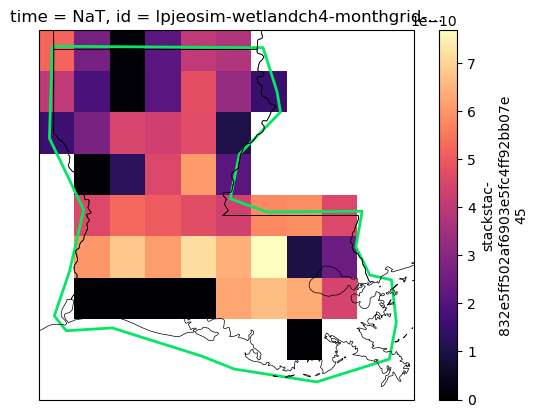

In [305]:
# Quick plot to visualize our data selection
fig=plt.figure()
ax1=fig.add_subplot(projection=ccrs.PlateCarree())
clip.sel(band=asset_name)[6,:,:].plot(ax=ax1,cmap='magma') # index 6 corresponds to July 2021
louisiana_aoi.plot(ax=ax1,facecolor='none',edgecolor='#04E762',linewidth=2)
ax1.add_feature(cf.STATES,linewidth=0.5)

### Calculate and apply area weights

Our CH4 emissions are in  `g m-2 month-1`, but our grid cells are in lat/lon space -  we need to calculate how many meters are in each grid cell, so we can calculate emissions in `g month-1`.

In [306]:
# We need the latitude values reversed to utilize surfaceAreaGrid correctly.
clip = clip.reindex(y=clip.y[::-1])
weights = surfaceAreaGrid.surfaceAreaGridd(
    lat_centers=clip.y.values,
    lon_centers=clip.x.values,
    ret_area=True)

In [307]:
# Apply these weights - simple as a multiplication
data_weighted = clip.sel(band=asset_name)*weights

In [308]:
# Take the total emissions over our polygon
means = data_weighted.sum(dim=['x','y'])

In [309]:
# Define year and month from start_datetime values
# and add them to the xarray DataArray, 
# specifying that they corresponds to the 'time' dimension.
means['year'] = (['time'],[datetime.fromisoformat(sd).year for sd in ds['start_datetime'].values])
means['month'] = (['time'],[datetime.fromisoformat(sd).strftime('%b') for sd in ds['start_datetime'].values])

### Plot time series

Text(0, 0.5, 'Total CH4 emissions, g')

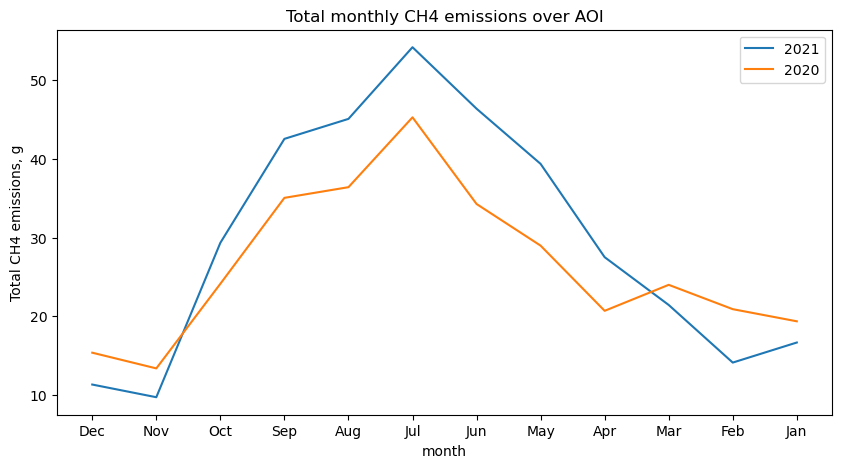

In [311]:
means[means['year']==years[1]].plot(x='month',label=str(years[1]),figsize=(10,5))
means[means['year']==years[0]].plot(x='month',label=str(years[0]))
plt.legend()
plt.title('Total monthly CH4 emissions over AOI')
plt.ylabel('Total CH4 emissions, g')

## Generate Statistics and Time Series Lineplots for MERRA2 Data in Year 2020, 2021


1. Monthly MERRA-2 Precipitation RateDataset: MERRA2_400.tavgM_2d_flx_Nx
Variable: `PRECTOT`
https://disc.gsfc.nasa.gov/datasets/M2TMNXFLX_5.12.4/summary

2. Monthly MERRA-2 Surface Soil MoistureDataset: MERRA2_400.tavgM_2d_lnd_Nx
Variable: `SFMC`
Long-term mean variable: `GWETTOP`
https://disc.gsfc.nasa.gov/datasets/M2TMNXLND_5.12.4/summary

3. Monthly MERRA-2 T2MDataset: MERRA2_400.instM_2d_asm_Nx
Variable: `T2M`
https://disc.gsfc.nasa.gov/datasets/M2IMNXASM_5.12.4/summary

4. MERRA-2 Long-Term MeansMERRA2.tavgC_2d_ltm_Nx
https://disc.gsfc.nasa.gov/datasets/M2TCNXLTM_1/summary

### NASA Earth Data Login Credentials
To download or stream NASA data you will need an Earthdata account, you can create one here <https://urs.earthdata.nasa.gov/home>. We will use the `login` function from the `earthaccess` library for authentication before downloading at the end of the notebook. This function can also be used to create a local `.netrc` file if it doesn’t exist or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you’ll be prompted for them. This step is not necessary to conduct searches but is needed to download or stream data.

In [20]:
# from netrc import netrc
# from subprocess import Popen
# from platform import system
# from getpass import getpass
# import os
# import requests
# import xarray as xr
# import s3fs
# import boto3
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.pyplot as plt
# import warnings
# from IPython.display import display, Markdown

# if (boto3.client('s3').meta.region_name == 'us-west-2'):
#     display(Markdown('### us-west-2 Region Check: &#x2705;'))
# else:
#     display(Markdown('### us-west-2 Region Check: &#10060;'))
#     raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

# urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
# prompts = ['Enter NASA Earthdata Login Username: ',
#            'Enter NASA Earthdata Login Password: ']

# netrc_name = ".netrc"

# # Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
# try:
#     netrcDir = os.path.expanduser(f"~/{netrc_name}")
#     # Check credentials against URS, and if username exists
#     netrc(netrcDir).authenticators(urs)[0]

# # Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
# except FileNotFoundError:
#     homeDir = os.path.expanduser("~")
#     Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
#     Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
#     Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
#     # Set restrictive permissions
#     Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

# gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

# # Define a function for S3 access credentials

# def begin_s3_direct_access(url: str=gesdisc_s3):
#     response = requests.get(url).json()
#     return s3fs.S3FileSystem(key=response['accessKeyId'],
#                              secret=response['secretAccessKey'],
#                              token=response['sessionToken'],
#                              client_kwargs={'region_name':'us-west-2'})

# fs = begin_s3_direct_access()

In [21]:
# fn = 's3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4'

# fs.info(fn)
# fs.ls('s3://gesdisc-cumulus-prod-protected/MERRA2/')

### Alternatively, load  for MERRA-2 Data from existing folder

### Opening and Exploring MERRA-2 Data 

In this notebook, we will explore the MERRA-2 data. We will visualize the outputs on a map using `folium`.

In [22]:
data_dir = f"{os.getenv('HOME')}/shared/agu-2024/activity-1/"   
merra_t2m_dir=f'{data_dir}/merra_t2m_dir/'
merra_soil_moisture_dir = f'{data_dir}/merra_soil_moisture_dir/'
merra_precip_rate_dir = f'{data_dir}/merra_precip_rate_dir/'
merra_t2m_clim_dir = f'{data_dir}/merra_t2m_clim_dir/'

merra_precip_rate_clim_dir = merra_t2m_clim_dir 
merra_soil_moisture_clim_dir = merra_t2m_clim_dir

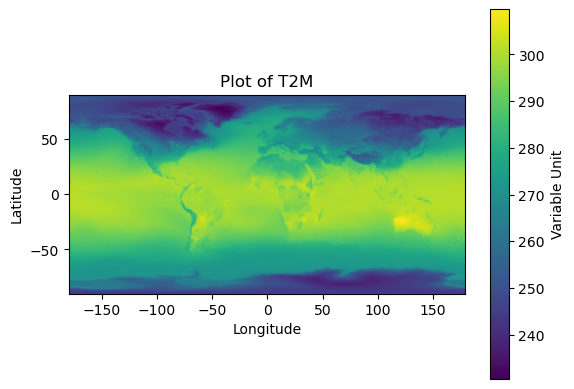

In [23]:
## visualize MERRA-2
# [-95.9,-87.50,28.7,33.5]

# Insert the path to the NetCDF file
file_path = f'{data_dir}/merra_t2m_dir/MERRA2_100.instM_2d_asm_Nx.199101.nc4'  # Replace with the path to your NetCDF file
dataset = nc.Dataset(file_path)


# Access coordinates (if needed)
latitude = dataset.variables['lat'][:]
longitude = dataset.variables['lon'][:]


# Access variables
variable_name = 'T2M'  # Replace with the variable you want to plot
# dataset.variables['T2M'][0, 237:248, 135:150]
variable_data = dataset.variables['T2M'][0, :,:]

# Close the NetCDF file
# dataset.close()
# Plot the data
plt.imshow(variable_data, origin='lower', cmap='viridis', extent=(longitude.min(), longitude.max(), latitude.min(), latitude.max()))
plt.colorbar(label='Variable Unit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Plot of {variable_name}')
plt.show()

In [24]:
print('variables provided in this netcdf are:', dataset.variables)

variables provided in this netcdf are: {'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    long_name: longitude
    units: degrees_east
    vmax: 1000000000000000.0
    vmin: -1000000000000000.0
    valid_range: [-1.e+15  1.e+15]
unlimited dimensions: 
current shape = (576,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    long_name: latitude
    units: degrees_north
    vmax: 1000000000000000.0
    vmin: -1000000000000000.0
    valid_range: [-1.e+15  1.e+15]
unlimited dimensions: 
current shape = (361,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    long_name: time
    units: minutes since 1991-01-01 00:00:00
    time_increment: 60000
    begin_date: 19910101
    begin_time: 0
    vmax: 1000000000000000.0
    vmin: -1000000000000000.0
    valid_range: [-1.e+15  1.e+15]
unlimited dimensions: time
current shape = (1,)
f

In [25]:
params={
    'MERRA-2 T2M':
        {'var':'T2M',
        'cmap':'#000000',
        'dir':merra_t2m_dir,
        'nickname':'merra2_t2m',
        'climdir':merra_t2m_clim_dir,
        'climvar':'T2MMEAN'},
    'MERRA-2 Surface Soil Moisture':
        {'var':'GWETTOP',
        'cmap':'#000000',
        'dir':merra_soil_moisture_dir,
        'nickname':'merra2_sm',
        'climdir':merra_soil_moisture_clim_dir,
        'climvar':'GWETTOP'},
    'MERRA-2 Precipitation Rate':
        {'var':'PRECTOT',
        'cmap':'#000000',
        'dir':merra_precip_rate_dir,
        'nickname':'merra2_pr',
        'climdir':merra_precip_rate_clim_dir,
        'climvar':'PRECTOT'}
}

year=1991

anomaly = 1
param = ['MERRA-2 Precipitation Rate','MERRA-2 Surface Soil Moisture', 'MERRA-2 T2M' ]

In [26]:
def get_merra2_timeseries(year,focus,p,anomaly):
    files = glob.glob(params[p]['dir']+'*.nc4') # change the year for which you want to read the files
    if anomaly:
        try:
            clim_files = glob.glob(params[p]['climdir']+'*.nc4')
        except:
            print('Climatological mean files (climdir) not found for specified parameter.')
            breakpoint()
    month_labels = []
    box_totals = []
    month_field = []
    dt = []
    for i,f in enumerate(files):
        data = nc.Dataset(f)
        
        #   Get bounding box
        wlat = np.logical_and(
            data['lat'][:] < boundaries[focus][3],
            data['lat'][:] > boundaries[focus][2]
        )
        wlon = np.logical_and(
            data['lon'][:] < boundaries[focus][1],
            data['lon'][:] > boundaries[focus][0]
        )

        datestamp = f.split('.')[-2]
        month = int(datestamp[-2::])

        dt.append(datetime(year,month,1))
        month_labels.append(datetime(year,month,1).strftime('%B'))

        if anomaly:
            #   Make sure you read the climatology for the right month (whichfile)
            whichfile = [datetime(1991,month,1).strftime('%y%m')[1:] in f for f in clim_files] # Change the year for the data being used.
            climdata = nc.Dataset(np.array(clim_files)[whichfile][0])
            
            #   Calculate sum (emissions) or mean (met params) over your bounding box
            if 'LPJ' in p:
                clim_box_total = np.nansum(climdata[params[p]['climvar']][0,wlat,wlon])
                now_box_total = np.nansum(data[params[p]['var']][0,wlat,wlon])
            elif 'MERRA' in p:
                clim_box_total = np.nanmean(climdata[params[p]['climvar']][0,wlat,wlon])
                now_box_total = np.nanmean(data[params[p]['var']][0,wlat,wlon])

            #   Replace fill values with NaN 
            #   Otherwise differencing might give wild results? (Just be safe)
            wfillclim = np.where(climdata[params[p]['climvar']][0,:,:] == climdata[params[p]['climvar']]._FillValue)
            climfield = climdata[params[p]['climvar']][0,:,:]
            climfield[wfillclim] = np.nan
            wfillnow = np.where(data[params[p]['var']][0,:,:] == data[params[p]['var']]._FillValue)
            nowfield = data[params[p]['var']][0,:,:]
            nowfield[wfillnow] = np.nan

            #   And finally, difference current month and long-term mean 
            box_totals.append(now_box_total - clim_box_total)
            month_field.append(nowfield - climfield)
            climdata.close()
        else:
            if 'LPJ' in p:
                box_totals.append(np.nansum(data[params[p]['var']][0,wlat,wlon]))
            elif 'MERRA' in p:
                box_totals.append(np.nanmean(data[params[p]['var']][0,wlat,wlon]))
            #   Replace fill values with NaN (otherwise maps are hard to read) 
            month_field.append(data[params[p]['var']][0,:,:])
            wfill = np.where(month_field[-1] == data[params[p]['var']]._FillValue)
            month_field[-1][wfill] = np.nan
            #breakpoint()

    #   Sort in case months are out of order
    dti = np.argsort(dt)
    month_labels = np.array(month_labels)[dti]
    box_totals = np.array(box_totals)[dti]
    month_field = np.array(month_field)[dti]

    # print('mean ',np.nanmean(month_field))
    # print('std ',np.nanstd(month_field))

    data_return = {
        'month_labels':month_labels,
        'box_totals':box_totals,
        'month_fields':month_field,
        'units':data[params[p]['var']].units,
        'lat':data['lat'][:],
        'lon':data['lon'][:],
        'mean':np.nanmean(month_field),
        'std' : np.nanstd(month_field)
    }
    data.close()
    return data_return 


Mean of variable MERRA-2 Precipitation Rate is -7.973682727424602e-07
Standard deviation of variable MERRA-2 Precipitation Rate is 1.885925667011179e-05


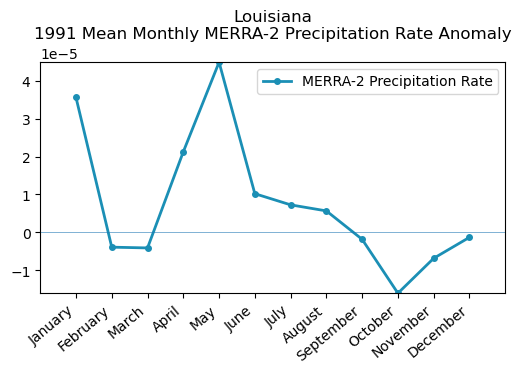

Mean of variable MERRA-2 Surface Soil Moisture is -0.00156168092507869
Standard deviation of variable MERRA-2 Surface Soil Moisture is 0.0329766683280468


<Figure size 640x480 with 0 Axes>

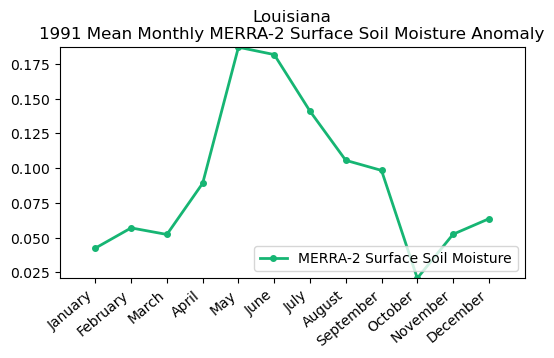

Mean of variable MERRA-2 T2M is -0.08452282100915909
Standard deviation of variable MERRA-2 T2M is 1.4482206106185913


<Figure size 640x480 with 0 Axes>

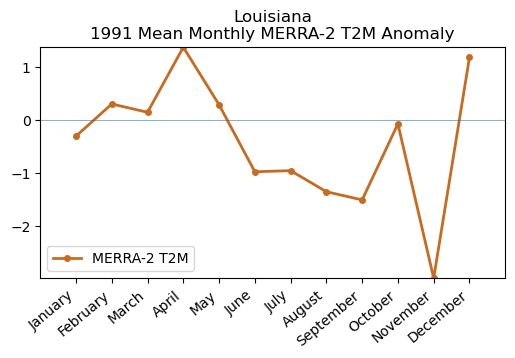

<Figure size 640x480 with 0 Axes>

In [27]:
# List of color codes assigned
colors = ['#1B8FB5', '#16B573', '#C76B21']
for i,p in enumerate(param):
    
    ts = get_merra2_timeseries(year,focus,p,anomaly)
    print(f'Mean of variable {p} is {ts["mean"]}')
    print(f'Standard deviation of variable {p} is {ts["std"]}')
        
    # if i == 0:
    fig= plt.figure(figsize=(6,3))
    ax = fig.add_subplot(1,1,1)

    #breakpoint()
    try:
        ax.plot(
            list(range(0,12)),
            ts['box_totals'],
            linestyle='-',
            linewidth=2,
            color=colors[i],
            markersize=4,
            marker='o',
            label=p
        )
    except ValueError:
        print('Double check that you have all twelve months of MERRA-2 data downloaded!')
        print(params[p]['dir'])
        breakpoint()

    #   Construct plot title
    title = '%s\n%s Mean Monthly %s'%(focus,year,p)
    if anomaly:
        title+=' Anomaly' 
    if 'LPJ' in p:
        title = title.replace('Mean','Total')
    plt.title(title)
    
    plt.xticks(list(range(0,12)))
    ax.set_xticklabels(ts['month_labels'],rotation=40,ha='right')


    ax.legend(loc='best')
    nickname = params[p]['nickname']
    savename = 'box_summed_%s_%s_%s.png'% \
        (nickname,year,focus)
    if anomaly:
        ax.plot(list(range(-1,13)),np.zeros(14),linewidth=0.4)
        savename = savename.replace('.png','_Anomaly.png')
    ax.set_xlim(-1,12)
    ax.set_ylim(min(ts['box_totals']),max(ts['box_totals']))     #   manual per parameter
    plt.show()
    plt.savefig(savename.split('/')[-1],dpi=300,bbox_inches='tight')